<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b> (Little demo) Exploring the DiaObject Duplication Issues in DP0.2</b> <br>
Contact author(s): Ryan Lau <br>
Last verified to run: 2024-04-16 <br>
LSST Science Pipelines version: Weekly 2024_04 <br>
Container Size: medium

## 1. Introduction

The purpose of this notebook is to demonstrate and characterize the DiaObject duplication issue identified in notebook DP02_07b "Variable Stars in DP0.2," where the same variable star can be identified with multiple DiaOjbectIds. The key goal of this notebook is to inform how this issue may or may not affect your scientific analysis of transients and/or variables. 

In Section 2, we demonstrate the diaObject duplication issue using the known RR Lyrae variable presented as an example in notebook DP02_07b. This known RR Lyrae star has two diaObjectIds associated with it within a 0.5'' radius, which highlights the issue with the source association algorithm in the LSST Pipeline that should associate diaSources with diaObjects within a 0.5'' radius. 

Lastly, in Section 3, we conduct a broader investigation of the diaObject duplication issue. We estimate the occurrence rate of duplicate diaObjectIds using a random sample of diaObjects from the diaObject catalog. We also investigate the types of sources affected by this using the TruthSummary table. 

### 1.1 Package Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service


### 1.2 Define Functions and Parameters

Setting the plot format parameters

In [2]:
%matplotlib inline
plt.style.use('tableau-colorblind10')
params = {'axes.labelsize': 24,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [10, 8],
          'figure.facecolor': 'White'}
plt.rcParams.update(params)

Start the TAP service, which we will use for all data retrieval in this notebook.

In [3]:
service = get_tap_service("tap")

## 2. Demonstration of DiaObject Duplication Issue on a Known RR Lyrae Variable

In this section, we will present an example of the DiaObject duplication issue using the known RR Lyrae Variable that was also presented as an example variable in notebook DP02_07b. 



### 2.1 Identifying Two DiaObjectIds associated with known variable from DiaSources

As in DP02_07b, the known RR Lyrae star we will use is at position (RA, Dec) = (62.1479031, -35.799138) degrees. 

We define the coordinate (ra and dec) of the known position this variable, and then obtain the diaSource properties including the associated diaObjectIds, total flux, and detector coordinate positions by conducting the following search. Note that we use a narrow search radius of 0.5'', which is the radius used for associating a diaSource with a known diaObject. Lastly, we sort the diaSources by 'midPointTai' for convenience of investigating when the diaObject duplication occurs.

In [4]:
ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, ccdVisitId,"
                             "filterName, midPointTai, psFlux, totFlux, totFluxErr, "
                             "apFlux, apFluxErr,psFluxErr, snr, x, y "
                             "FROM dp02_dc2_catalogs.DiaSource "
                             "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                             "CIRCLE('ICRS'," + str(ra_known_rrl) + ", "
                             + str(dec_known_rrl) + ", 0.000139)) = 1 ", maxrec=100000)
DiaSrcs = results.to_table()
DiaSrcs.sort('midPointTai')
del results

We can identify the unique diaObjects from the resulting 'DiaSrcs' table.

In [5]:
DiaObjIds = list(set(DiaSrcs['diaObjectId']))
print(DiaObjIds)
print('The first DiaObject assigned to this target is %s' %DiaSrcs['diaObjectId'][0])

[1651589610221864014, 1651589610221862935]
The first DiaObject assigned to this target is 1651589610221862935


If the DIA source association is working propertly, there should only be one DiaObject associated with the 0.5'' search of a true astrophysical source. The occurance of a duplicate DiaObjectId indicates an issue with the source association. Note that the first DiaObjectId created for this target is 1651589610221862935. The duplicate DiaObjectId is 1651589610221864014.

The following cell will identify the MJD when the duplicate DiaObject was created and show where in the DiaSrcs table this occurs.

In [6]:
mjd_dup = DiaSrcs[np.where(DiaSrcs['diaObjectId']==1651589610221864014)]['midPointTai'][0]
DiaSrcs[np.where(DiaSrcs['midPointTai']==mjd_dup)]

ra,decl,diaObjectId,diaSourceId,ccdVisitId,filterName,midPointTai,psFlux,totFlux,totFluxErr,apFlux,apFluxErr,psFluxErr,snr,x,y
deg,deg,,,,,d,nJy,nJy,nJy,nJy,nJy,nJy,,pix,pix
float64,float64,int64,int64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
62.1479247,-35.7991881,1651589610221864014,132418215086129194,246648146,y,59920.0852722,-10544.2596714,25.3716272,1471.2778349,-10236.3789545,3096.2979329,1429.8846702,-3.3060077,2922.1159668,167.2229919
62.1479247,-35.7991881,1651589610221862935,132418215086129193,246648146,y,59920.0852722,-10544.2596714,169557.0571863,1472.3262522,-10236.3789545,3096.2979329,1429.8846702,-3.3060077,2922.1159668,167.2229919


Surprisingly, the DiaObject duplication seems to have occured on the same visit where a diaSource was associated with the original diaObject (1651589610221862935) with nearly identical measure DiaSource properties (excepted 'totFlux').

### 2.2 Light curve and coordinate properties of DiaSources associated with known variable

We can plot the light curve (y-band) of both diaObjects to investigate if they perhaps exhibit distinct brightnesses and/or levels of variability

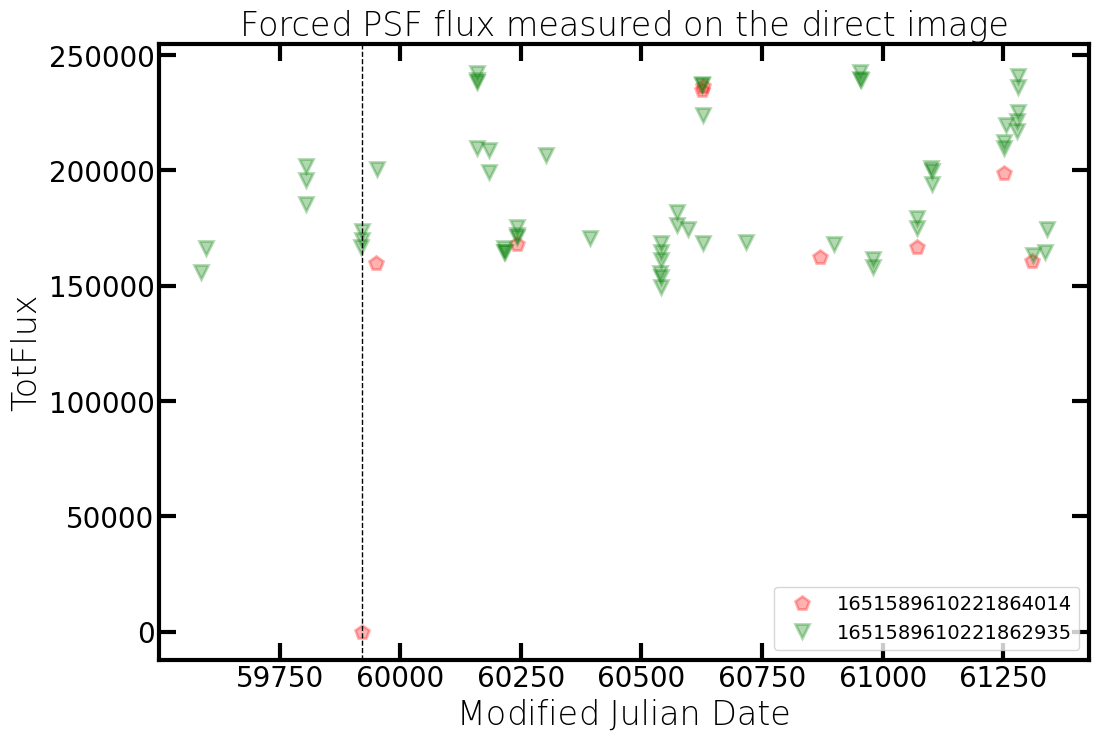

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 8))
DiaObjIds = list(set(DiaSrcs['diaObjectId']))
filt = 'y'


for j in np.arange(len(DiaObjIds)):
    fx = np.where((DiaSrcs['diaObjectId']==DiaObjIds[j]) & (DiaSrcs['filterName']==filt))[0]
    ax.plot(DiaSrcs['midPointTai'][fx], DiaSrcs['totFlux'][fx],['p','v','^','o'][j], ms=10,color = ['r','g','b','y'][j], mew=2, mec=['r','g','b','y'][j],
            alpha=0.3, label=DiaObjIds[j])

#Plotting line indicating MJD where duplicate DiaObject is created
plt.axvline(x = mjd_dup,color = 'black', ls = '--', lw = 1)

ax.set_xlabel('Modified Julian Date')
ax.set_ylabel('TotFlux')
ax.set_title('Forced PSF flux measured on the direct image')
ax.legend(loc='lower right')

plt.show()

Other than the initial low value of the first diaSource associated with the duplicate diaObject (1651589610221864014), the light curve appears to indicate that both diaObjects are indeed associated with the same variable star.

In the following cell, we plot the measured ra and dec offsets from the known coordinates of the variable star for both diaObjects (in all filters).

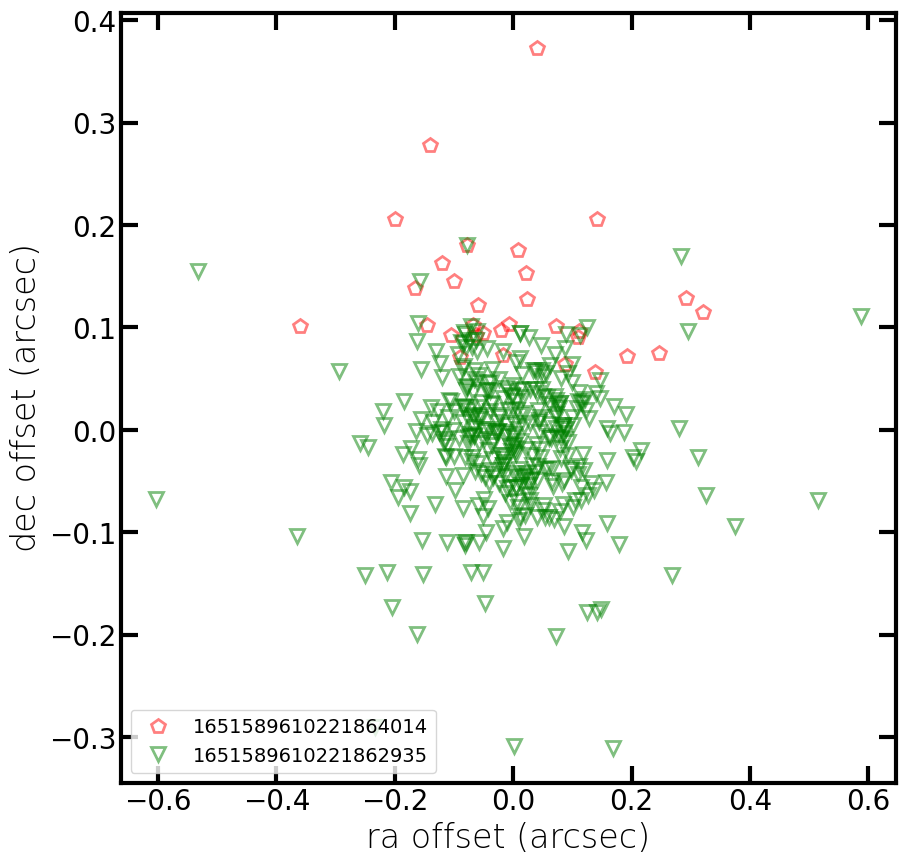

In [8]:
fig, ax = plt.subplots(1, figsize=(10, 10))
DiaObjIds = list(set(DiaSrcs['diaObjectId']))


for j in np.arange(len(DiaObjIds)):
    fx = np.where(DiaSrcs['diaObjectId']==DiaObjIds[j])
    ax.plot((ra_known_rrl-DiaSrcs['ra'][fx])*3600, (dec_known_rrl-DiaSrcs['decl'][fx])*3600,
               ['p','v','^','o'][j], ms=10, mew=2, mec=['r','g','b','y'][j],
               alpha=0.5, color='none', label='%s' % DiaObjIds[j])

ax.set_xlabel('ra offset (arcsec)')
ax.set_ylabel('dec offset (arcsec)')
ax.legend(loc='lower left')


#plt.subplots_adjust(wspace=.0)

plt.show()

As shown in the offset coordinate plot, the diaSources associated with both diaObjects are within 0.5'' of eachother and therefore should not have been split into two diaObjects.

## 3. Broader Investigation of DiaObject Duplication Issue

In this section, we estimate the occurrence rate of the diaObject duplication issue by obtaining a random sample of diaObjects from the DiaObject catalog, and verify the types of objects that are affected by this using the TruthSummary table.

### 3.1. Estimated Occurrence Rate of DiaObject Duplication Issue

First, we grab a random sample of 100 DiaObjects that have at least 10 detections to help ensure they are associated with real astrophysical transients/variables and not arising from spurious diaSource detections. 

In [9]:
nDiaSources_min = 10

results = service.search("SELECT TOP 100 "
                         "ra, decl, diaObjectId, nDiaSources "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > "+str(nDiaSources_min)+" ")
DiaObjs = results.to_table()
del results

In the following cell, we conduct a coordinate search through the DiaSource catalog for the sample of diaObjects obtained above to identify DiaSources within a 0.5'' radius of the diaObject coordinates. 

The resulting DiaSources will notably include the diaObjectId(s) they are associated with. The diaObject duplication issue will manifest as multiple diaObjectIds for a specific coordinate position.

We will keep track of the number of duplicate diaObjectIds for each of the diaObject position in an array labeled "NDup," which we use to create an "nDuplicates" column for the DiaObjs table. The following cell should take less than 30 seconds to execute.

In [10]:
NDup = np.zeros(len(DiaObjs))
for i in np.arange(len(DiaObjs)):
    ra = DiaObjs['ra'][i]
    decl = DiaObjs['decl'][i]
    results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, ccdVisitId,"
                             "filterName, midPointTai "
                             "FROM dp02_dc2_catalogs.DiaSource "
                             "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                             "CIRCLE('ICRS'," + str(ra) + ", "
                             + str(decl) + ", 0.000139)) = 1 ", maxrec=100000) #0.5'' radius coordinate search
    DiaSrcs = results.to_table()
    del results
    NDup[i]=len(list(set(DiaSrcs['diaObjectId'])))-1
DiaObjs['nDuplicates']=NDup

We can estimate the occurrence frequency of the diaObject duplication issue by calculating what fraction of the DiaObject sample has at least one duplicate diaObject.

In [11]:
len(NDup[NDup>0])/len(NDup)

0.61

The results of the above cell indicates that >~50% of diaObjects are affected by the diaObject duplication issue, which could present significant issues for statistical analyses of transients and variables. 

### 3.2. Investigating DiaObject Truth Type affected by Duplication Issue

In order to investigate the type of sources (i.e. variables vs transients) that are producing the duplication issue, we will grab a random sample of diaObjects associated with variable stars and SNe and identify how many diaObjects of each type have duplicates. In order to verify the diaObject type, we utilize the TruthSummary table, the DESC DC2 truth catalog as described in arXiv:2101.04855.

**First, we will explore the variable stars with diaObject duplicates**. We conduct a (1''-radius) coordinate search in the TruthSummary table for the diaObjects with duplicates identified in the random sample of diaObjects obtained in Sec. 3.1. The following cell should take around 30 seconds to execute.


In [12]:
Var = np.zeros(len(DiaObjs))
for i in np.arange(len(DiaObjs)):
    ra = DiaObjs['ra'][i]
    decl = DiaObjs['decl'][i]
    results = service.search("SELECT ts.ra, ts.dec, ts.is_variable, ts.truth_type "
                             "FROM dp02_dc2_catalogs.TruthSummary AS ts "
                             "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), "
                             "CIRCLE('ICRS'," + str(ra) + ", "
                             + str(decl) + ", 0.00028)) = 1 ", maxrec=100000)
    SrcTruth = results.to_table()
    if 1 in SrcTruth['is_variable'] and 2 in SrcTruth[SrcTruth['is_variable']==1]['truth_type']:
        Var[i] = 1
    else:
        Var[i] = 0
    del results
DiaObjs['Var']=Var

print('Out of the %s diaObjects that are associated with a variable star'
      ' (i.e. is_variable = 1 and truth_type = 2), %s have duplicates.' % 
      (len(DiaObjs[DiaObjs['Var']==1]),len(DiaObjs[(DiaObjs['nDuplicates']>0) & (DiaObjs['Var']==1)])))


Out of the 93 diaObjects that are associated with a variable star (i.e. is_variable = 1 and truth_type = 2), 58 have duplicates.


The results of the search in the previous cell indicate that roughly ~50% of the diaObjects associated with a variable star has duplicate diaObjects.

**Now we explore the SNe with diaObject duplicates.** In order to grab a sample of Type Ia SN candidates, we utilize the search parameters described in the DP02 07a notebook "DiaObject Sample Identification." (See notebook 07a for more details).

In [13]:
snia_peak_mr_min = 18.82
snia_peak_mr_max = 22.46

snia_ampl_mr_min = 1.5
snia_ampl_mr_max = 5.5

snia_peak_mg_max = 24.0
snia_peak_mi_max = 24.0

snia_nDiaSources_min = 15
snia_nDiaSources_max = 100

snia_duration_min = 50
snia_duration_max = 300

Conducting a search for 150 diaObjects associated with Type Ia SN candidates.

In [14]:
results = service.search("SELECT TOP 150 "
                         "ra, decl, diaObjectId, nDiaSources, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin) AS rMagMax, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) AS gMagMin, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) AS iMagMin "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > "+str(snia_nDiaSources_min)+" "
                         "AND nDiaSources < "+str(snia_nDiaSources_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_peak_mr_min)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_peak_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(gPSFluxMax) < "+str(snia_peak_mg_max)+" "
                         "AND scisql_nanojanskyToAbMag(iPSFluxMax) < "+str(snia_peak_mi_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_ampl_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_ampl_mr_min)+" ")

DiaObjsSN = results.to_table()
del results

In the following cell, we identify duplicates in the sample of SN candidates. The following cell takes around 30 seconds to execute.

In [15]:
NDup = np.zeros(len(DiaObjsSN))
for i in np.arange(len(DiaObjsSN)):
    ra = DiaObjsSN['ra'][i]
    decl = DiaObjsSN['decl'][i]
    results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, ccdVisitId,"
                             "filterName, midPointTai "
                             "FROM dp02_dc2_catalogs.DiaSource "
                             "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                             "CIRCLE('ICRS'," + str(ra) + ", "
                             + str(decl) + ", 0.000139)) = 1 ", maxrec=100000) #0.5'' radius coordinate search
    DiaSrcs = results.to_table()
    del results
    NDup[i]=len(list(set(DiaSrcs['diaObjectId'])))-1
DiaObjsSN['nDuplicates']=NDup

Laslty, we utilize the TruthSummary table to confirm which candidates are true SNe and determine how many of the diaObjects associated with true SN have duplicates. The following cell takes around 1 min to execute.

In [16]:
SN = np.zeros(len(DiaObjsSN))
for i in np.arange(len(DiaObjsSN)):
    ra = DiaObjsSN['ra'][i]
    decl = DiaObjsSN['decl'][i]
    results = service.search("SELECT ts.ra, ts.dec, ts.is_variable, ts.truth_type "
                             "FROM dp02_dc2_catalogs.TruthSummary AS ts "
                             "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), "
                             "CIRCLE('ICRS'," + str(ra) + ", "
                             + str(decl) + ", 0.00028)) = 1 ", maxrec=100000)
    SrcTruth = results.to_table()
    if 3 in SrcTruth['truth_type']:
        SN[i] = 1
    else:
        SN[i] = 0
    del results
DiaObjsSN['SN']=SN
print('Out of the %s diaObjects that are associated with a supernova (i.e. truth_type = 3), %s have duplicates.' 
      % (len(DiaObjsSN[DiaObjsSN['SN']==1]),len(DiaObjsSN[(DiaObjsSN['nDuplicates']>0) & (DiaObjsSN['SN']==1)])))

Out of the 9 diaObjects that are associated with a supernova (i.e. truth_type = 3), 2 have duplicates.


The results of the search in the previous cell indicate that roughly ~20% of the diaObjects associated with a SN has duplicate diaObjects. 

**Note.** The results of the diaObject search 3 cells above will result in a difference set of 150 diaObjects each time the search is executed. Therefore, the number of diaObjects associated with SN and those with duplicates in the previous cell will change each time the search is re-run.

In conclusion, the analysis indicates that diaObjects associated with variable stars are more likely to be impacted than diaObjects associated with transients / SNe. 